# Skin Cancer detection using Convolutional Neural Networks 
This project focuses on developing and evaluating deep learning models for classifying skin lesions into multiple diagnostic categories using dermoscopic images.  
We use the **DERM12345** dataset, which contains 12,345 high-resolution images and rich metadata covering 40 lesion subtypes grouped into 7 clinically relevant classes.  

Two model architectures were implemented:  
- A **custom CNN** built from scratch for baseline performance.  
- A **DenseNet-121** model with transfer learning for improved accuracy and generalization.  

To address **class imbalance**, techniques such as class weighting, targeted data augmentation, and stratified patient-safe splits were used.  
The project also integrates **Grad-CAM** for explainability, highlighting the image regions most influential to each prediction.  
This ensures the model’s decisions are interpretable, supporting trust and adoption in clinical settings.  


## 1. Loading and Inspecting Metadata

Before preprocessing, we first load the **metadata.csv** file to understand the dataset's structure and quality.

- **Load dataset**: Reads the metadata from `metadata.csv` into a Pandas DataFrame.  
- **Check dimensions**: Prints the total number of rows and columns to understand dataset size.  
- **Preview sample records**: Displays the first few rows for a quick look at the data format.  
- **Identify missing values**: Counts missing entries in each column to plan data cleaning.  
- **List all columns**: Shows the names of all metadata fields for reference in later processing.

In [18]:
import pandas as pd

df = pd.read_csv("derm12345/metadata.csv")

print(f"Total rows: {df.shape[0]}, Total columns: {df.shape[1]}")

print("\nSample rows:")
print(df.head())

print("\nMissing values per column:")
print(df.isnull().sum())


print("\nColumns in dataset:")
print(df.columns.tolist())


Total rows: 12345, Total columns: 14

Sample rows:
        isic_id              attribution copyright_license  \
0  ISIC_0052262  Imperial College London             CC-BY   
1  ISIC_0073753  Imperial College London             CC-BY   
2  ISIC_0075741  Imperial College London             CC-BY   
3  ISIC_0076451  Imperial College London             CC-BY   
4  ISIC_0077281  Imperial College London             CC-BY   

  anatom_site_general anatom_site_special diagnosis_1  \
0                 NaN                 NaN      Benign   
1                 NaN                 NaN      Benign   
2                 NaN                 NaN      Benign   
3                 NaN                 NaN      Benign   
4                 NaN                 NaN   Malignant   

                                       diagnosis_2       diagnosis_3  \
0                  Benign epidermal proliferations     Solar lentigo   
1                Benign melanocytic proliferations             Nevus   
2                

In [19]:
missing = df.isnull().sum()
print(missing[missing > 0])


anatom_site_general       11449
anatom_site_special       11449
diagnosis_2                  12
diagnosis_3                  12
diagnosis_4                2160
diagnosis_5                6208
diagnosis_confirm_type    11178
dtype: int64


## 2. Grouping Diagnosis Labels into Broader Categories

The dataset contains many specific diagnosis labels, which can make classification harder due to small sample sizes in certain classes.  
In this step, we **map fine-grained diagnoses into seven clinically meaningful groups** to simplify classification while retaining clinical relevance.

- **Create `group_map`**: A dictionary mapping detailed diagnoses (e.g., *Nodular melanoma*, *Kaposi sarcoma*) to broader groups such as `Melanoma`, `BCC`, `Keratosis`, `Vascular`, `Other_Benign`, and `Other_Malignant`.
- **Apply mapping**: Use the `diagnosis_3` column to generate a new column `diagnosis_grouped` with these grouped categories.
- **Handle missing mappings**: Assign any unmatched entries to the category `Other_Malignant`.
- **Check distribution**: Print the count of each grouped label to verify balance and confirm the mapping worked.
- **Save grouped metadata**: Store the updated metadata in a new file `metadata_grouped.csv` for downstream preprocessing and model training.

In [20]:

group_map = {
    "Melanoma in situ": "Melanoma",
    "Melanoma, NOS": "Melanoma",
    "Superficial spreading melanoma": "Melanoma",
    "Nodular melanoma": "Melanoma",
    "Lentigo maligna melanoma": "Melanoma",
    "Melanoma, metastatic": "Melanoma",

    "Basal cell carcinoma": "BCC",
    "Pigmented basal cell carcinoma": "BCC",
    "Nodular basal cell carcinoma": "BCC",

    "Squamous cell carcinoma": "SCC",
    "Keratoacanthoma": "SCC",

    "Nevus": "Nevus",
    "Congenital nevus": "Nevus",
    "Spitz nevus": "Nevus",
    "Atypical nevus": "Nevus",
    "Combined nevus": "Nevus",
    "Blue nevus": "Nevus",

    "Seborrheic keratosis": "Keratosis",
    "Solar lentigo": "Keratosis",
    "Actinic keratosis": "Keratosis",
    "Lichen planus-like keratosis": "Keratosis",

    "Hemangioma": "Vascular",
    "Angiokeratoma": "Vascular",
    "Kaposi sarcoma": "Vascular",

    "Dermatofibroma": "Other_Benign",
    "Cyst": "Other_Benign",
    "Other": "Other_Benign",  
}

df["diagnosis_grouped"] = df["diagnosis_3"].map(group_map)
df["diagnosis_grouped"] = df["diagnosis_grouped"].fillna("Other_Malignant")


print("Grouped Labels:\n", df["diagnosis_grouped"].value_counts())

df.to_csv("derm12345/metadata_grouped.csv", index=False)

Grouped Labels:
 diagnosis_grouped
Nevus              9952
Keratosis           667
Other_Malignant     603
BCC                 423
Melanoma            299
Vascular            221
Other_Benign        180
Name: count, dtype: int64


## 3. Visualizing Class Distribution and Calculating Class Weights

After grouping the diagnoses, it’s important to understand **how balanced or imbalanced the dataset is**. This step helps in deciding whether we need techniques like class weighting or augmentation.

- **Load grouped metadata**: Read `metadata_grouped.csv` generated in the previous step.
- **Count samples per class**: Use `value_counts()` to see how many images belong to each grouped category.
- **Visualize distribution**: Plot a bar chart using Seaborn to clearly show class imbalances (e.g., Nevus having far more samples than rare classes like Vascular).
- **Calculate class weights**: Compute a dictionary of weights based on the inverse frequency of each class. These weights will be used in the loss function to give more importance to underrepresented classes during training.
- **Print weights**: Display the calculated weights for review before integrating them into the training pipeline.

/var/folders/zz/l0xs3l6953s9jqg6gt6wkfqc0000gn/T/ipykernel_21437/1492202555.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")


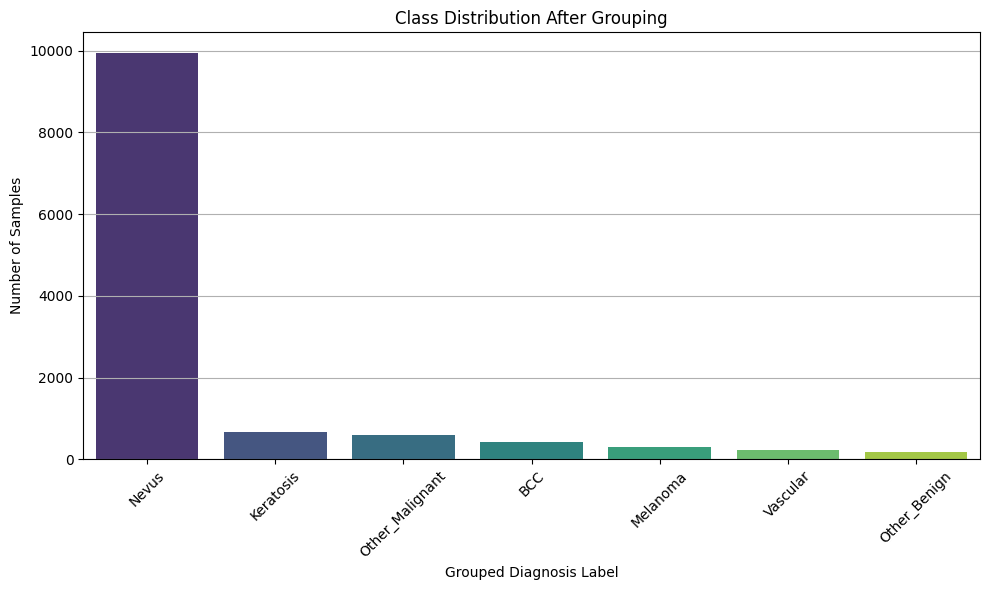


 Class Weights for Training:
{'Nevus': 1.24, 'Keratosis': 18.51, 'Other_Malignant': 20.47, 'BCC': 29.18, 'Melanoma': 41.29, 'Vascular': 55.86, 'Other_Benign': 68.58}


In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("derm12345/metadata_grouped.csv")

class_counts = df["diagnosis_grouped"].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.title("Class Distribution After Grouping")
plt.ylabel("Number of Samples")
plt.xlabel("Grouped Diagnosis Label")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.tight_layout()
plt.show()

total = len(df)
class_weights = {cls: round(total / count, 2) for cls, count in class_counts.items()}
print("\n Class Weights for Training:")
print(class_weights)

## 4. Metadata Cleaning and Preparing for Model Input

This step ensures that only **relevant and non-leakage-prone columns** remain in the dataset, and also prepares essential fields for model training.

- **Load grouped metadata**: Read the file `metadata_grouped.csv` created earlier.
- **Drop unnecessary columns**: Remove attribution, license info, anatomical site columns, redundant diagnosis fields, and diagnosis confirmation type, as they either have too many missing values or may cause data leakage.
- **Recalculate class weights**: Generate weights based on the inverse frequency of each label for balanced learning.
- **Map class weights to each sample**: Add a new `class_weight` column to the DataFrame for easier use during training.
- **Add image paths**: Create an `image_path` column linking each image’s ID to its actual file location for later loading in CNN pipelines.
- **Save cleaned metadata**: Export the processed DataFrame as `grouped_metadata_cleaned.csv` for the next stages of preprocessing and training.

In [22]:
import pandas as pd

df = pd.read_csv("derm12345/metadata_grouped.csv")  

drop_cols = [
    "attribution", "copyright_license",
    "anatom_site_general", "anatom_site_special",
    "diagnosis_1", "diagnosis_2", "diagnosis_4",
    "diagnosis_5", "diagnosis_confirm_type"
]
df = df.drop(columns=drop_cols, errors="ignore")  

# class weights
class_counts = df["diagnosis_grouped"].value_counts()
total_samples = len(df)
class_weights = {label: round(total_samples / count, 2) for label, count in class_counts.items()}

# Add class weight per sample 
df["class_weight"] = df["diagnosis_grouped"].map(class_weights)

# image path for loading later in CNN
df["image_path"] = "derm12345/images/" + df["isic_id"] + ".jpg"

df.to_csv("derm12345/grouped_metadata_cleaned.csv", index=False)
print('File saved')

File saved


## 5. Patient-Safe Data Splitting and Encoding

In this step, the dataset is split into **training, validation, and test sets** while ensuring **patient-level separation** to prevent data leakage and maintain realistic evaluation.

- **Load cleaned metadata**: Start from `grouped_metadata_cleaned.csv`.
- **Drop incomplete samples**: Remove rows missing `diagnosis_grouped` or `patient_id`.
- **Aggregate patient-level labels**: Assign each patient the most common lesion type in their images.
- **Stratified patient-level split**:
  - **Train (≈72.25%)**
  - **Validation (≈12.75%)**
  - **Test (15%)**
  This ensures all sets maintain similar class distribution while keeping patients exclusive to a single split.
- **Fill missing auxiliary fields**: Replace `image_type` NAs with `"Unknown"` and `melanocytic` NAs with `False`.
- **Encode categorical data**:
  - `image_type` → numerical encoding for potential metadata use.
  - `diagnosis_grouped` → label-encoded as `label_encoded` for model training.
- **Save final metadata file**: Export as `grouped_metadata_modelready.csv` containing all necessary columns for model loading, training, and evaluation.

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv("derm12345/grouped_metadata_cleaned.csv")

df = df.dropna(subset=["diagnosis_grouped", "patient_id"])

patient_labels = df.groupby("patient_id")["diagnosis_grouped"].agg(lambda x: x.mode().iloc[0]).reset_index()

train_val_patients, test_patients = train_test_split(
    patient_labels,
    test_size=0.15,
    stratify=patient_labels["diagnosis_grouped"],
    random_state=42
)

train_patients, val_patients = train_test_split(
    train_val_patients,
    test_size=0.15 / 0.85,
    stratify=train_val_patients["diagnosis_grouped"],
    random_state=42
)

df["split"] = "unassigned"
df.loc[df["patient_id"].isin(train_patients["patient_id"]), "split"] = "train"
df.loc[df["patient_id"].isin(val_patients["patient_id"]), "split"] = "val"
df.loc[df["patient_id"].isin(test_patients["patient_id"]), "split"] = "test"

df["image_type"] = df["image_type"].fillna("Unknown")
df["melanocytic"] = df["melanocytic"].fillna(False)

image_encoder = LabelEncoder()
df["image_type_encoded"] = image_encoder.fit_transform(df["image_type"])

label_encoder = LabelEncoder()
df["label_encoded"] = label_encoder.fit_transform(df["diagnosis_grouped"])

final_df = df[[
    "isic_id", "diagnosis_grouped", "label_encoded", "split",
    "class_weight", "image_type", "image_type_encoded",
    "melanocytic", "patient_id", "image_path"
]]

final_df.to_csv("derm12345/grouped_metadata_modelready.csv", index=False)
print("File saved")


File saved


## 6. Image Transforms & Class-Aware Augmentation 

This cell defines **two transform pipelines** and applies them to a **small sample** of images to verify preprocessing works end‑to‑end.

- **Load split/labels** from `grouped_metadata_modelready.csv`.
- **Define base transform** (resize → tensor → normalize) for common classes.
- **Define augmentation transform** (resize → random flip/rotation → light color jitter → tensor → normalize) for **rare classes** to help counter class imbalance.
- **Identify rare classes**: any class with `< 1000` samples (simple heuristic).
- **Preview step**: randomly select 5 images, apply the appropriate transform (augmented for rare classes; base otherwise), and collect tensors.


In [24]:
import pandas as pd
import os
from PIL import Image
from torchvision import transforms
from collections import Counter
from tqdm import tqdm

df = pd.read_csv("derm12345/grouped_metadata_modelready.csv")

IMAGE_SIZE = 224

base_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  
])

augment_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

label_counts = df["diagnosis_grouped"].value_counts()
rare_classes = label_counts[label_counts < 1000].index.tolist()

sample_df = df.sample(5, random_state=42)
image_tensors = []

for _, row in tqdm(sample_df.iterrows(), total=5):
    image_path = os.path.join("derm12345", "images", f"{row['isic_id']}.jpg")
    
    if not os.path.exists(image_path):
        continue
    
    img = Image.open(image_path).convert("RGB")
    transform = augment_transform if row["diagnosis_grouped"] in rare_classes else base_transform
    img_tensor = transform(img)
    image_tensors.append(img_tensor)

print("Sample tensor shape:", image_tensors[0].shape if image_tensors else "No image loaded")


100%|██████████| 5/5 [00:00<00:00, 107.17it/s]

Sample tensor shape: torch.Size([3, 224, 224])


## 7. Custom Dataset Class & DataLoader Setup

This cell creates a **custom PyTorch Dataset** for our skin cancer images and sets up DataLoaders for training, validation, and testing.

- **Load dataset splits** (`train`, `val`, `test`) from `grouped_metadata_modelready.csv`.
- **Define transforms**:
  - `base_transform` → Resize → Tensor → Normalize.
  - `augment_transform` → Adds flip, rotation, and color jitter for **rare classes** (< 1000 samples) to boost diversity.
- **Map class names to numeric indices** for model training.
- **Define `SkinCancerDataset`**:
  - Reads image paths from the CSV.
  - Applies **class-aware augmentation** (rare classes get augmented; others get base transform).
  - Returns image tensors and numeric labels.
- **Split into PyTorch Dataset objects** for each data subset.
- **Wrap datasets in DataLoaders** for batched, shuffled loading.

**Why this is important:**
- Keeps augmentation **targeted** at imbalanced classes without overprocessing the majority classes.
- DataLoaders allow efficient GPU feeding with batching and shuffling.
- Custom Dataset makes it easy to extend for metadata-based models later.


In [25]:
import pandas as pd
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from collections import Counter

df = pd.read_csv("derm12345/grouped_metadata_modelready.csv")

# Define image size and transforms
IMAGE_SIZE = 224

base_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

augment_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

label_counts = df["diagnosis_grouped"].value_counts()
rare_classes = label_counts[label_counts < 1000].index.tolist()

class_names = sorted(df["diagnosis_grouped"].unique())
class_to_idx = {cls_name: i for i, cls_name in enumerate(class_names)}
df["label_idx"] = df["diagnosis_grouped"].map(class_to_idx)

class SkinCancerDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform, rare_classes):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform
        self.rare_classes = rare_classes

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_path = os.path.join(self.image_dir, f"{row['isic_id']}.jpg")
        image = Image.open(image_path).convert("RGB")
        
        transform = augment_transform if row["diagnosis_grouped"] in self.rare_classes else base_transform
        image = transform(image)
        label = row["label_idx"]

        return image, label

train_df = df[df["split"] == "train"]
val_df = df[df["split"] == "val"]
test_df = df[df["split"] == "test"]

image_folder = "derm12345/images"

train_dataset = SkinCancerDataset(train_df, image_folder, base_transform, rare_classes)
val_dataset = SkinCancerDataset(val_df, image_folder, base_transform, rare_classes)
test_dataset = SkinCancerDataset(test_df, image_folder, base_transform, rare_classes)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Train size:", len(train_dataset))
print("Validation size:", len(val_dataset))
print("Test size:", len(test_dataset))

Train size: 8549
Validation size: 1907
Test size: 1889


## Visual Inspection of Sample Images from Each Class

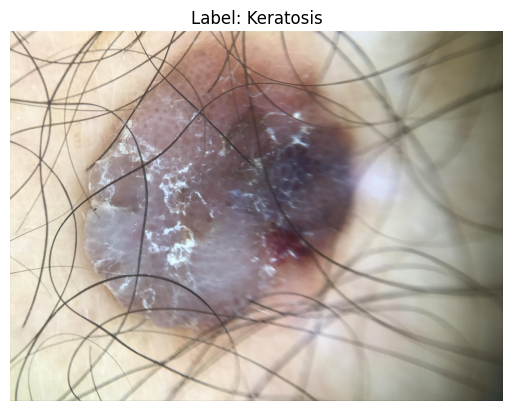

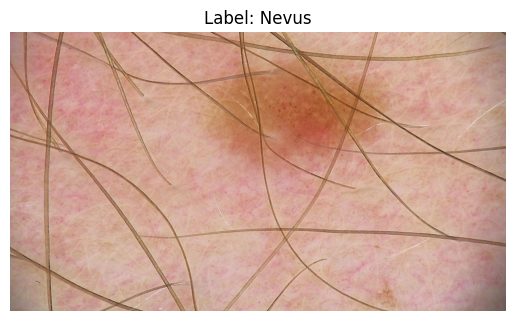

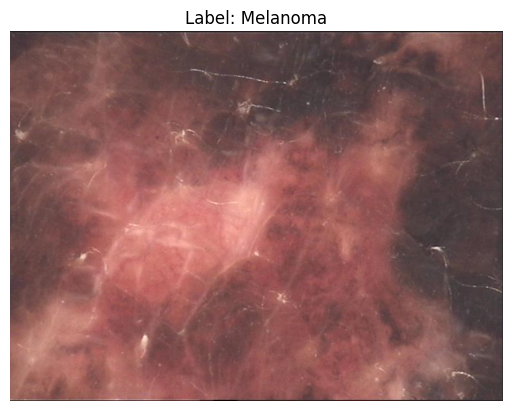

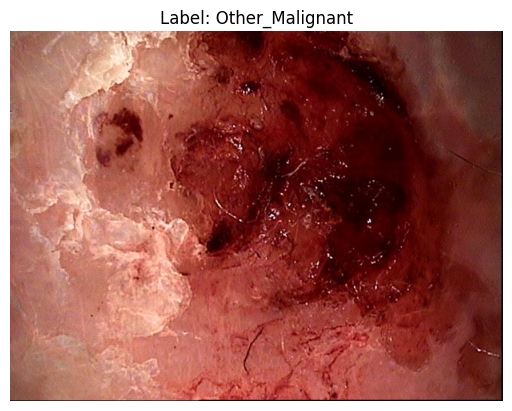

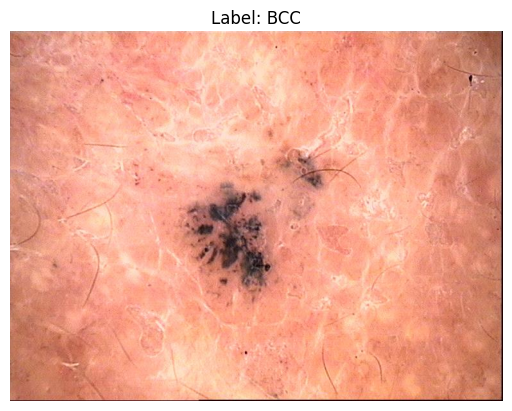

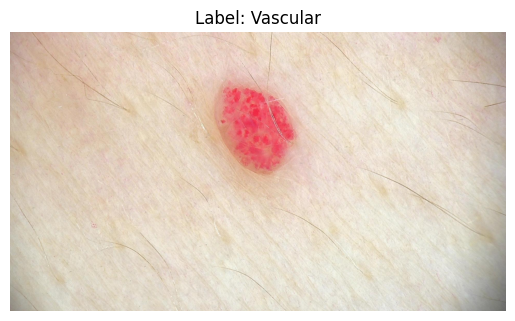

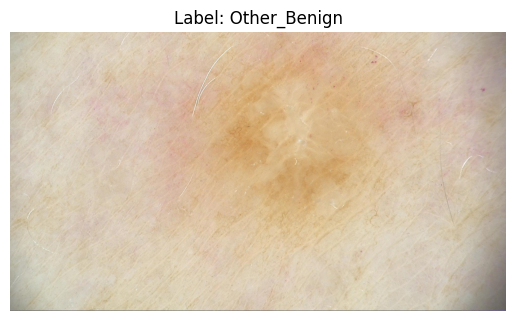

In [26]:
import os
import matplotlib.pyplot as plt
from PIL import Image

image_dir = "derm12345/images"

classes = df['diagnosis_grouped'].unique()

for cls in classes:
    row = df[df['diagnosis_grouped'] == cls].sample(1, random_state=42).iloc[0]
    image_path = os.path.join(image_dir, f"{row['isic_id']}.jpg")

    if os.path.exists(image_path):
        img = Image.open(image_path).convert("RGB")
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Label: {row['diagnosis_grouped']}")
        plt.show()
    else:
        print(f" Image not found for ID: {row['isic_id']}")

## 8. Custom CNN Architecture (Baseline)

This cell defines a lightweight **Convolutional Neural Network** used as a **baseline** before switching to transfer learning.

**What the network does:**
- **Feature extraction:** Three `Conv2d → ReLU → MaxPool2d` blocks (32→64→128 channels) learn increasingly abstract visual patterns from dermoscopic images.
- **Spatial squeeze:** `AdaptiveAvgPool2d(4×4)` standardizes feature-map size regardless of input image scaling.
- **Regularization:** `Dropout(0.4)` reduces overfitting on minority classes.
- **Classification head:** Flatten → `Linear(128×4×4 → 512)` → `Linear(512 → 7)` outputs logits for the 7 grouped classes.


In [27]:
import torch
import torch.nn as nn

class SkinCancerCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(SkinCancerCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))
        self.dropout = nn.Dropout(0.4)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.pool3(torch.relu(self.conv3(x)))
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(torch.relu(self.fc1(x)))
        return self.fc2(x)

## 9. Compute Class Weights for Imbalance

This cell derives **per-class weights** to counter the heavy skew toward *Nevus*.

- Count samples per `diagnosis_grouped`.
- Compute inverse-frequency weights: `weight_c = total / count_c`.
- Build a `torch.tensor` of weights (one per class) to pass into `nn.CrossEntropyLoss(weight=...)`.

**Why this matters**
- Raises the loss contribution of **minority classes** (e.g., *Vascular*, *Other_Benign*), improving recall without oversampling.



In [28]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.optim.lr_scheduler import ReduceLROnPlateau
from collections import Counter

df = pd.read_csv("derm12345/grouped_metadata_modelready.csv")

class_counts = Counter(df["diagnosis_grouped"])
total = sum(class_counts.values())

class_weights = {cls: total / count for cls, count in class_counts.items()}

class_names = sorted(class_counts.keys())
weights = [class_weights[cls] for cls in class_names]
class_weights_tensor = torch.tensor(weights, dtype=torch.float)
print("Class weights used for loss function:", class_weights_tensor)

Class weights used for loss function: tensor([29.1844, 18.5082, 41.2876,  1.2405, 68.5833, 20.4726, 55.8597])


## 10. DenseNet-121 Model Setup

- **Device Selection** → Checks if a GPU is available and uses it; otherwise defaults to CPU. This ensures faster training when possible.  
- **Load Pretrained Model** → DenseNet-121, already trained on ImageNet, is loaded to leverage learned visual features.  
- **Freeze Feature Layers** → The convolutional feature extractor is frozen so that only the final classification layer is trained.  
- **Custom Classifier** → The original classifier is replaced with a fully connected layer that outputs predictions for 7 skin lesion classes.  
- **Loss Function** → CrossEntropyLoss is used along with precomputed class weights to handle class imbalance.  
- **Optimizer** → Adam optimizer is set with a learning rate of 0.001 for efficient weight updates.  
- **Learning Rate Scheduler** → ReduceLROnPlateau lowers the learning rate by 50% if validation loss stops improving for 2 consecutive epochs.  

In [29]:
import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.densenet121(pretrained=True)
for param in model.features.parameters():
    param.requires_grad = False  

model.classifier = nn.Linear(model.classifier.in_features, 7)
model = model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor.to(device))
print("Class weights used for loss function:", class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

/Users/vasukhare/Desktop/Thesis/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/vasukhare/Desktop/Thesis/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Class weights used for loss function: tensor([29.1844, 18.5082, 41.2876,  1.2405, 68.5833, 20.4726, 55.8597])


In [31]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

def train(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=10):
    best_val_loss = float('inf')
    early_stop_counter = 0
    patience = 3

    for epoch in range(num_epochs):
        model.train()
        train_loss, correct_train, total_train = 0, 0, 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1} - Training"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_acc = 100 * correct_train / total_train
        avg_train_loss = train_loss / len(train_loader)

        model.eval()
        val_loss, correct_val, total_val = 0, 0, 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1} - Validation"):
                images, labels = images.to(device), labels.to(device)rt
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        val_acc = 100 * correct_val / total_val
        avg_val_loss = val_loss / len(val_loader)
        scheduler.step(avg_val_loss)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f}, Acc: {train_acc:.2f}% | Val Loss: {avg_val_loss:.4f}, Acc: {val_acc:.2f}%")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            early_stop_counter = 0
            torch.save(model.state_dict(), "best_skin_cancer_cnn.pth")
            print("Best model saved.")
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print("Early stopping.")
                break

train(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=10)

Epoch 1 - Validation: 100%|██████████| 60/60 [04:33<00:00,  4.55s/it]


Epoch 1 | Train Loss: 1.2713, Acc: 81.75% | Val Loss: 1.1103, Acc: 85.63%
Best model saved.


Epoch 2 - Validation: 100%|██████████| 60/60 [04:31<00:00,  4.52s/it]


Epoch 2 | Train Loss: 0.9507, Acc: 87.25% | Val Loss: 1.0845, Acc: 88.67%
Best model saved.


Epoch 3 - Validation: 100%|██████████| 60/60 [04:42<00:00,  4.70s/it]


Epoch 3 | Train Loss: 0.8694, Acc: 88.22% | Val Loss: 0.9908, Acc: 90.09%
Best model saved.


Epoch 4 - Validation: 100%|██████████| 60/60 [05:51<00:00,  5.86s/it]


Epoch 4 | Train Loss: 0.7833, Acc: 88.93% | Val Loss: 0.9609, Acc: 89.98%
Best model saved.


Epoch 5 - Validation: 100%|██████████| 60/60 [04:19<00:00,  4.32s/it]


Epoch 5 | Train Loss: 0.7280, Acc: 90.41% | Val Loss: 0.9794, Acc: 86.89%


Epoch 6 - Validation: 100%|██████████| 60/60 [04:45<00:00,  4.76s/it]


Epoch 6 | Train Loss: 0.7039, Acc: 90.37% | Val Loss: 0.9419, Acc: 90.30%
Best model saved.


Epoch 7 - Validation: 100%|██████████| 60/60 [05:09<00:00,  5.15s/it]


Epoch 7 | Train Loss: 0.6626, Acc: 91.40% | Val Loss: 0.9689, Acc: 90.09%


Epoch 8 - Validation: 100%|██████████| 60/60 [04:29<00:00,  4.49s/it]


Epoch 8 | Train Loss: 0.6930, Acc: 90.55% | Val Loss: 0.8668, Acc: 90.25%
Best model saved.


Epoch 9 - Validation: 100%|██████████| 60/60 [04:27<00:00,  4.46s/it]


Epoch 9 | Train Loss: 0.6377, Acc: 91.20% | Val Loss: 1.0145, Acc: 88.20%


Epoch 10 - Validation: 100%|██████████| 60/60 [04:30<00:00,  4.51s/it]

Epoch 10 | Train Loss: 0.6363, Acc: 91.27% | Val Loss: 0.9190, Acc: 90.25%


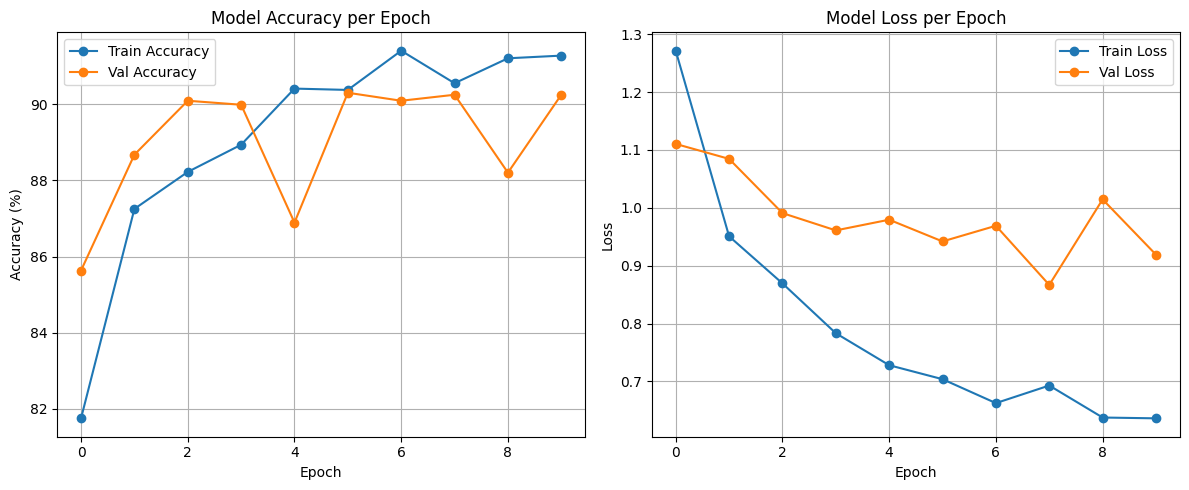

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy', marker='o')
plt.plot(val_accuracies, label='Val Accuracy', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Model Accuracy per Epoch")
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Val Loss', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Model Loss per Epoch")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Classification Report:
                 precision    recall  f1-score   support

            BCC       0.58      0.45      0.50        85
      Keratosis       0.74      0.48      0.59        99
       Melanoma       0.40      0.66      0.50        44
          Nevus       0.99      0.96      0.98      1495
   Other_Benign       0.34      0.63      0.44        27
Other_Malignant       0.51      0.71      0.59       109
       Vascular       0.42      0.47      0.44        30

       accuracy                           0.88      1889
      macro avg       0.57      0.62      0.58      1889
   weighted avg       0.90      0.88      0.89      1889



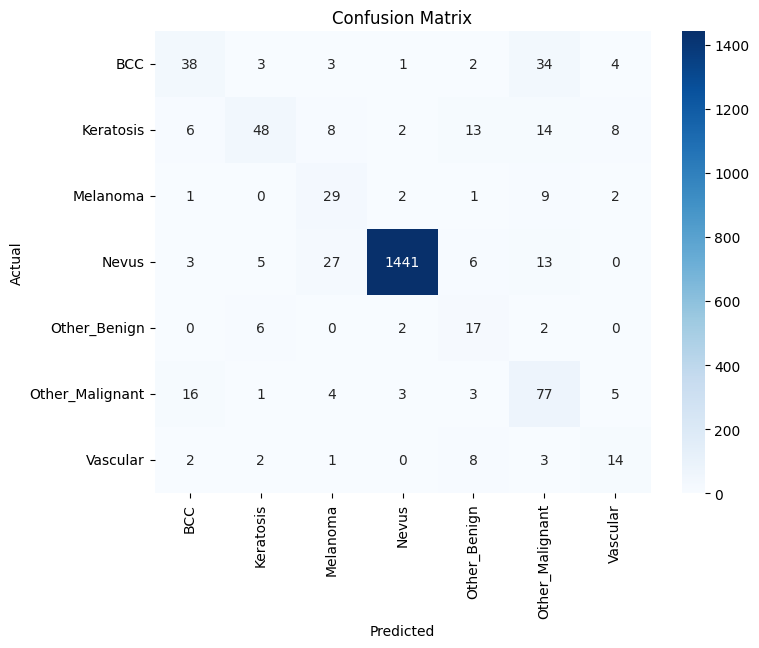

In [33]:
import torch
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the best model
model.load_state_dict(torch.load("best_skin_cancer_cnn.pth"))
model.to(device)
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

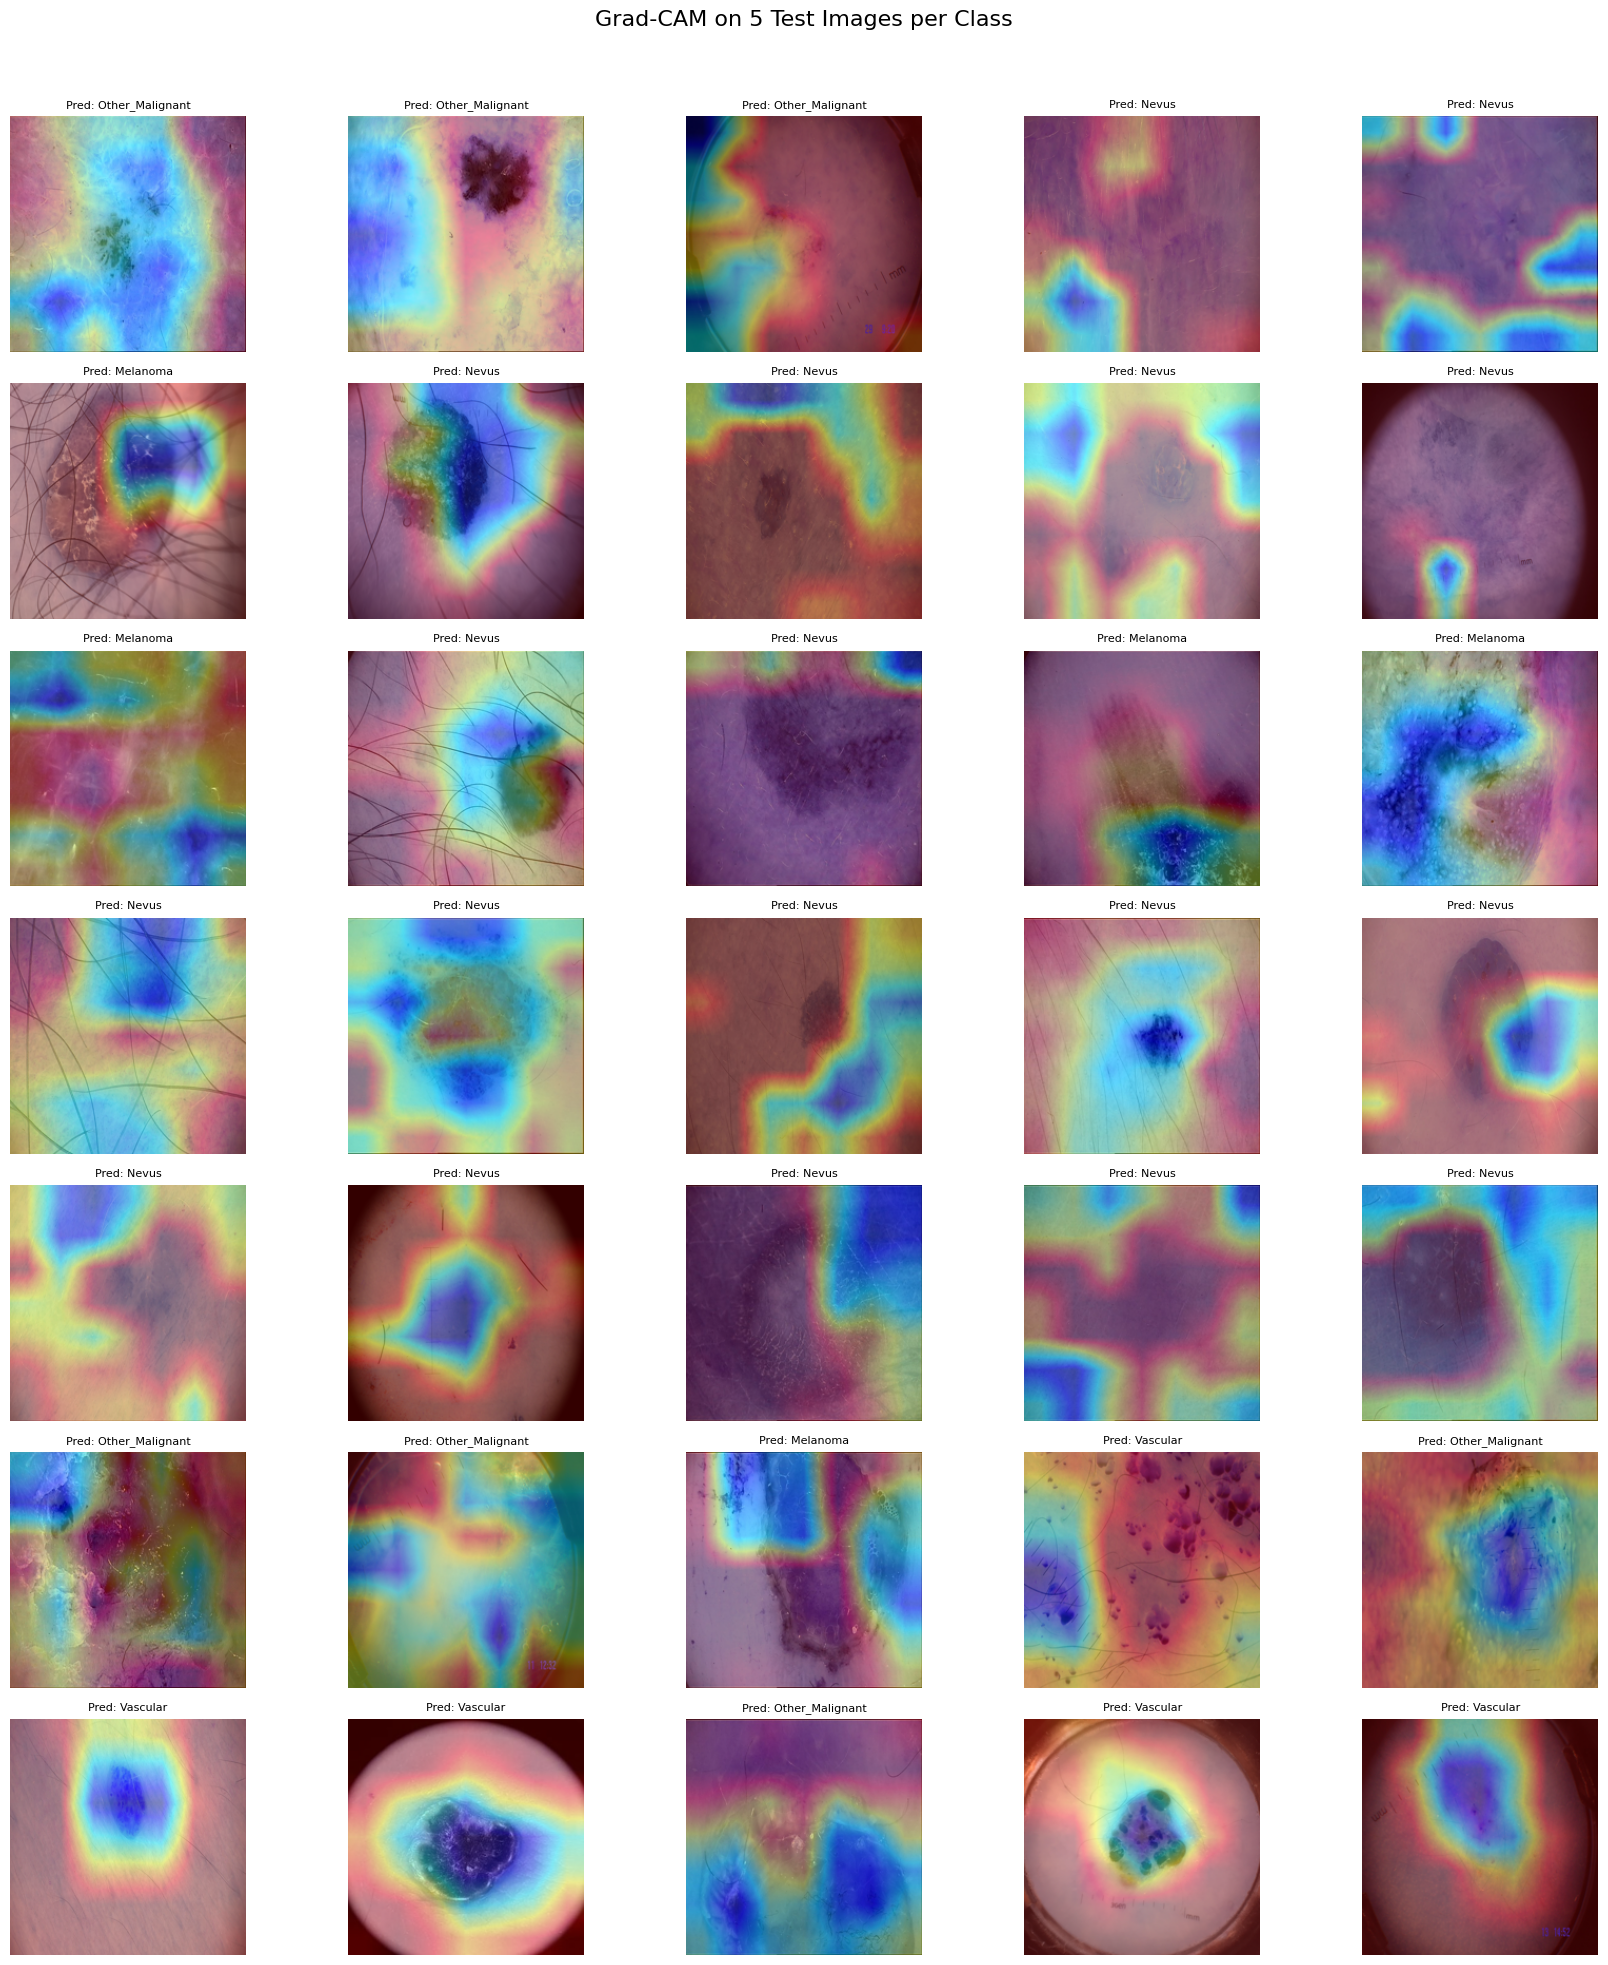

In [40]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import cv2
import pandas as pd
from torchvision import models
import torch.nn.functional as F
import random
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("derm12345/grouped_metadata_modelready.csv")
image_dir = "derm12345/images"

class_names = ['BCC', 'Keratosis', 'Melanoma', 'Nevus', 'Other_Benign', 'Other_Malignant', 'Vascular']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def load_model():
    model = models.densenet121(pretrained=True)
    model.classifier = torch.nn.Linear(model.classifier.in_features, 7)
    model.load_state_dict(torch.load("best_skin_cancer_cnn.pth", map_location=device))
    model.to(device)
    model.eval()
    return model

# Grad-CAM
def generate_gradcam(img_path, model):
    gradients = []
    activations = []

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    def forward_hook(module, input, output):
        activations.append(output)

    target_layer = model.features.denseblock4
    target_layer.register_forward_hook(forward_hook)
    target_layer.register_backward_hook(backward_hook)

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    img = Image.open(img_path).convert("RGB")
    input_tensor = transform(img).unsqueeze(0).to(device)

    output = model(input_tensor)
    pred_class = output.argmax(dim=1).item()

    model.zero_grad()
    output[0, pred_class].backward()

    pooled_grad = torch.mean(gradients[0], dim=[0, 2, 3])
    for i in range(activations[0].shape[1]):
        activations[0][:, i, :, :] *= pooled_grad[i]

    heatmap = torch.mean(activations[0], dim=1).squeeze()
    heatmap = F.relu(heatmap)
    heatmap = heatmap.cpu().detach().numpy()
    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))

    img_np = np.array(img.resize((224, 224)))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    overlay = heatmap_color * 0.4 + img_np[..., ::-1] * 0.6

    return np.uint8(overlay), pred_class

# 5 images per class
samples = []
for cls in class_names:
    subset = df[df["diagnosis_grouped"] == cls].sample(n=5, random_state=42)
    samples.extend(subset["isic_id"].values)

model = load_model()
fig, axs = plt.subplots(7, 5, figsize=(18, 20))
plt.subplots_adjust(wspace=0.1, hspace=0.4)

for idx, isic_id in enumerate(samples):
    row, col = divmod(idx, 5)
    img_path = os.path.join(image_dir, f"{isic_id}.jpg")
    if not os.path.exists(img_path): continue

    heatmap, pred = generate_gradcam(img_path, model)
    axs[row, col].imshow(heatmap)
    axs[row, col].axis('off')
    axs[row, col].set_title(f"Pred: {class_names[pred]}", fontsize=8)

plt.suptitle("Grad-CAM on 5 Test Images per Class", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [43]:
import torch
import numpy as np

model.eval()
y_true = []
y_pred = []
y_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_probs.extend(probs.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_probs = np.array(y_probs)

class_names = ['BCC', 'Keratosis', 'Melanoma', 'Nevus', 'Other_Benign', 'Other_Malignant', 'Vascular']

## Pre-Class Confusion Matrices

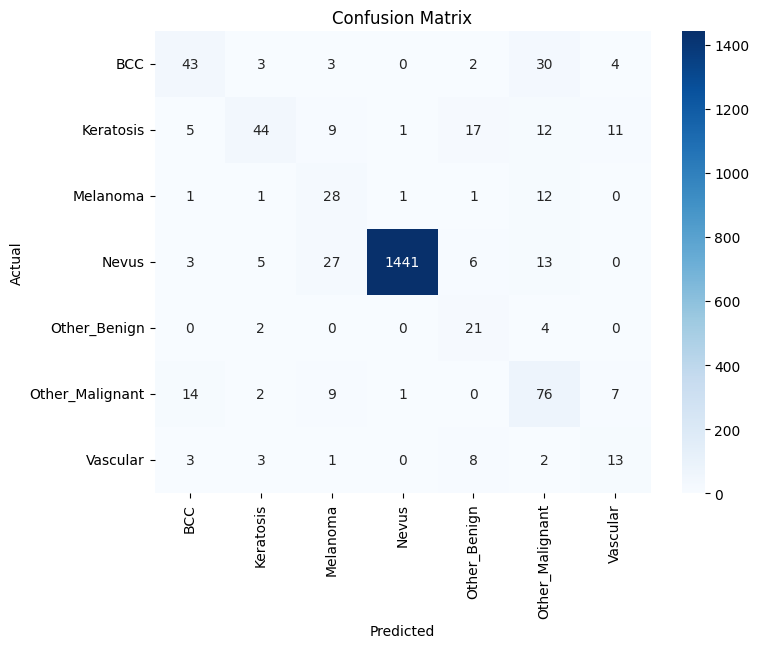

In [44]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## ROC-AUC for Each Class

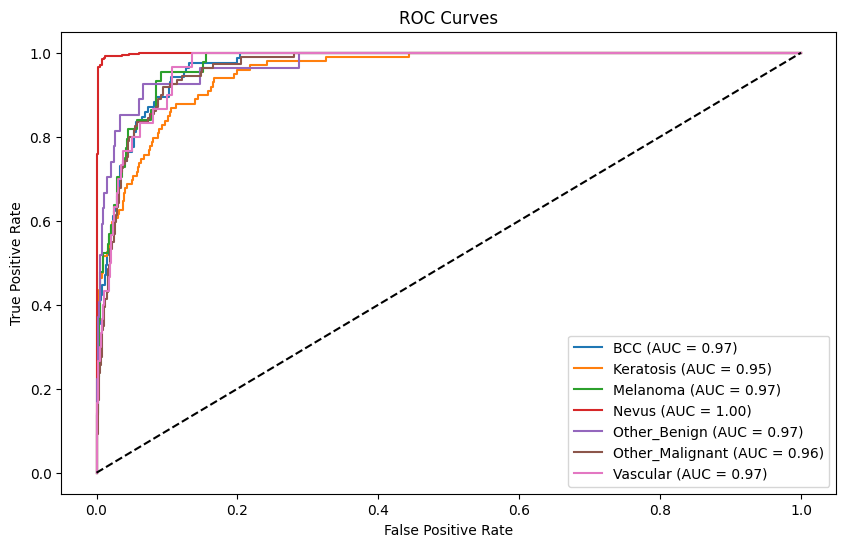

In [45]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_true_bin = label_binarize(y_true, classes=list(range(len(class_names))))
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 6))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

## Precision-Recall Curves (Pre Class)

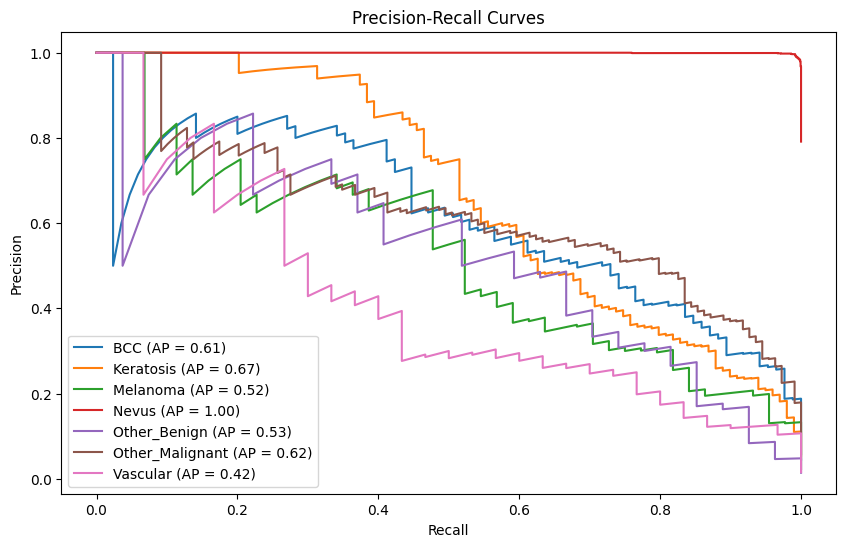

In [46]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(10, 6))
for i in range(len(class_names)):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_probs[:, i])
    ap = average_precision_score(y_true_bin[:, i], y_probs[:, i])
    plt.plot(recall, precision, label=f"{class_names[i]} (AP = {ap:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend()
plt.show()

## Calibration Curve

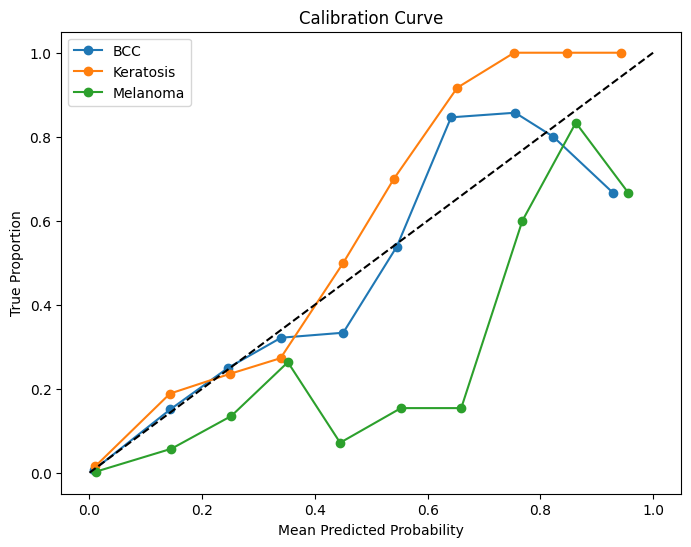

In [47]:
from sklearn.calibration import calibration_curve

plt.figure(figsize=(8,6))
for i in range(3):  # show for first 3 classes only
    prob_true, prob_pred = calibration_curve(y_true_bin[:, i], y_probs[:, i], n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=class_names[i])
plt.plot([0, 1], [0, 1], 'k--')
plt.title("Calibration Curve")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("True Proportion")
plt.legend()
plt.show()

## Grad-CAM Average Heatmap

In [48]:
import pandas as pd

misclassified = []
for i in range(len(y_pred)):
    if y_pred[i] != y_true[i]:
        misclassified.append({
            "True Label": class_names[y_true[i]],
            "Predicted Label": class_names[y_pred[i]],
            "Confidence": y_probs[i].max()
        })

df_mis = pd.DataFrame(misclassified)
df_mis.to_csv("misclassified_report.csv", index=False)
df_mis.head(10)

True Label  Predicted Label  Confidence
0         Melanoma  Other_Malignant    0.736900
1         Vascular  Other_Malignant    0.572165
2            Nevus         Melanoma    0.666413
3            Nevus         Melanoma    0.968150
4              BCC  Other_Malignant    0.424884
5              BCC  Other_Malignant    0.310515
6        Keratosis         Melanoma    0.362403
7         Vascular     Other_Benign    0.484305
8            Nevus  Other_Malignant    0.469544
9  Other_Malignant         Melanoma    0.589310